In [1]:
%matplotlib notebook

In [2]:
import foldable_robotics
import foldable_robotics.dxf 
import numpy
import matplotlib.pyplot as plt
import shapely.geometry as sg
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1

Shape: [[(0.0, 0), (10, 0), (10, 10)], [(1.5, 1), (9.5, 1), (9.5, 9)]]


In [3]:
filename = 'fivebar1.dxf'

In [4]:
body = foldable_robotics.dxf.read_lwpolylines(filename,layer='body')

<IPython.core.display.Javascript object>


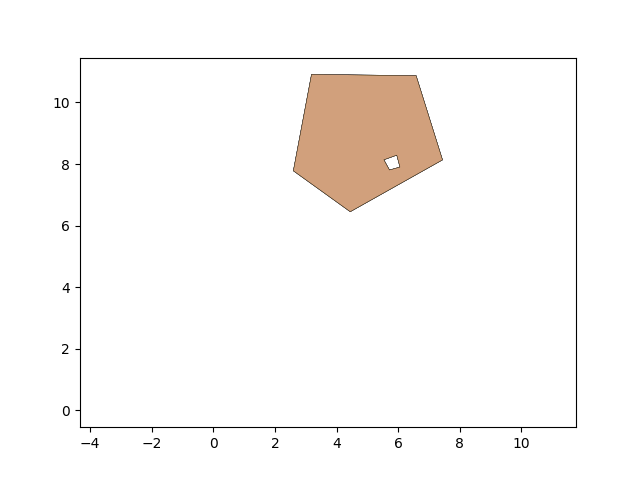

In [5]:
bodies = [Layer(sg.Polygon(item)) for item in body]
body = bodies.pop(0)
for item in bodies:
    body ^= item
body = body.to_laminate(5)
body.plot()

In [6]:
hinges_up = foldable_robotics.dxf.read_lines(filename,layer='hinge up')
hinges_down = foldable_robotics.dxf.read_lines(filename,layer='hinge down')
hinges = hinges_down+hinges_up

<IPython.core.display.Javascript object>


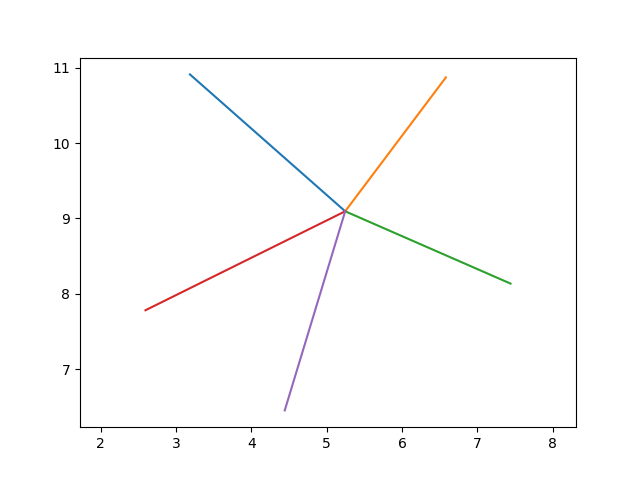

(2.3515989717223658, 7.6818200514138821, 6.2278380462724927, 11.13406426735218)

In [7]:
fig = plt.figure()
for hinge in numpy.array(hinges):
    plt.plot(hinge[:,0],hinge[:,1])
plt.axis('equal')

<IPython.core.display.Javascript object>


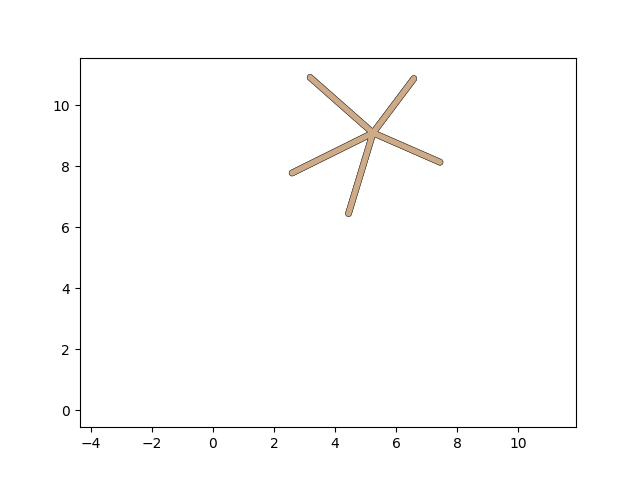

In [8]:
simple_hinges = Layer()
for item in hinges:
    simple_hinges |= Layer(sg.LineString(item))
simple_hinges<<=.1
simple_hinges = Laminate(simple_hinges,simple_hinges,Layer(),simple_hinges,simple_hinges)
simple_hinges.plot(new=True)

<IPython.core.display.Javascript object>


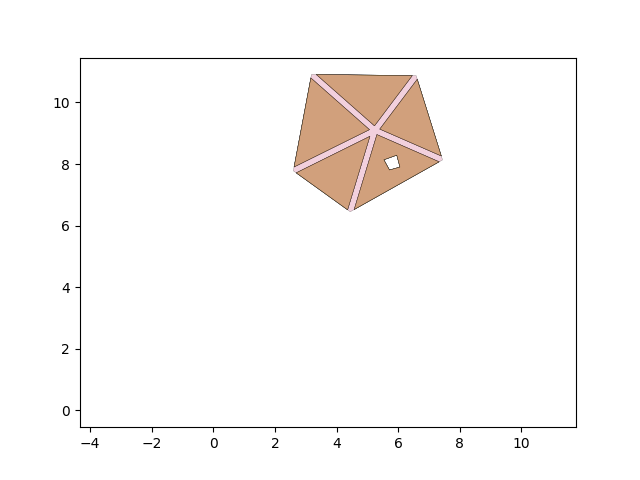

In [9]:
design = body-simple_hinges
design.plot(new=True)

<IPython.core.display.Javascript object>


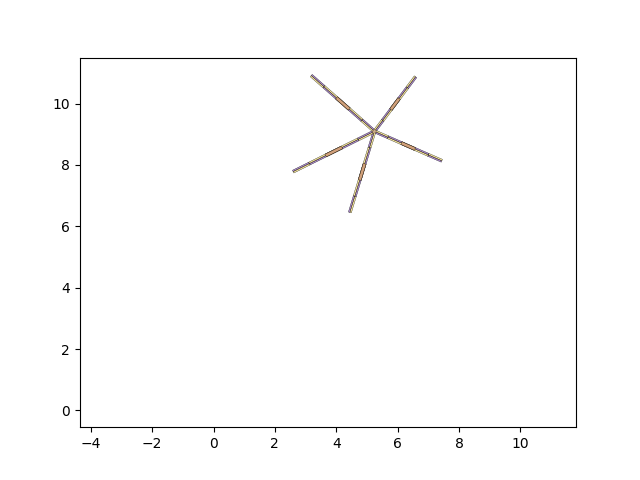

In [10]:
castellated_hinge = foldable_robotics.parts.castellated_hinge1.generate()
castellated_hinge = castellated_hinge.scale(1,.1)

castellated_hinges = Layer().to_laminate(5)
for p3,p4 in hinges:
    castellated_hinges|=castellated_hinge.map_line_stretch((0,0),(1,0),p3,p4)

castellated_hinges.plot(new=True)

In [11]:
cut_lines = foldable_robotics.dxf.read_lines(filename,layer='cuts')
cut_lines += foldable_robotics.dxf.read_lwpolylines(filename,layer='cuts')

<IPython.core.display.Javascript object>


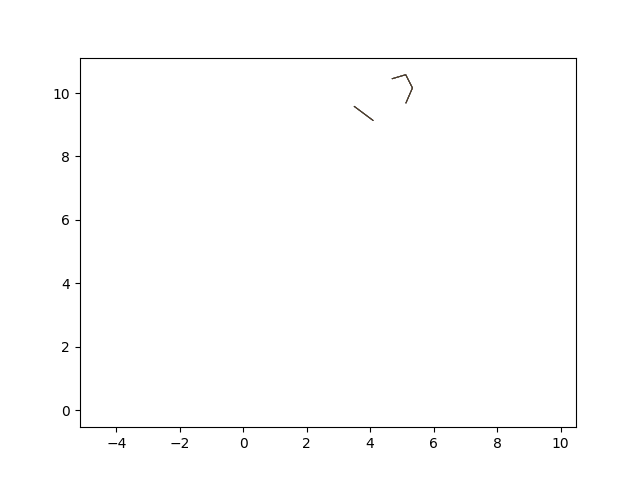

In [12]:
cuts = Layer()
for item in cut_lines:
    cuts |= Layer(sg.LineString(item))
cuts<<=.01
cuts = cuts.to_laminate(5)
cuts.plot(new=True)

<IPython.core.display.Javascript object>


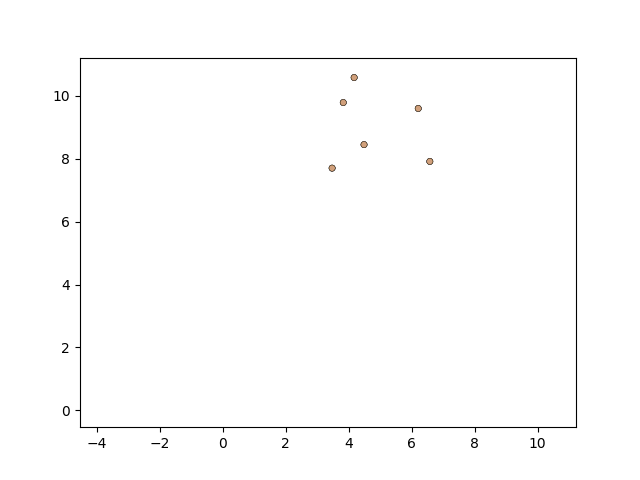

In [13]:
holes = foldable_robotics.dxf.read_lwpolylines(filename,layer='holes')
points = []
for item in holes:
    for vertex in item:
        points.append(sg.Point(*vertex))
holes_layer = Layer(*points)
holes_layer<<=.1
holes_lam = holes_layer.to_laminate(5)
holes_lam.plot(new=True)

<IPython.core.display.Javascript object>


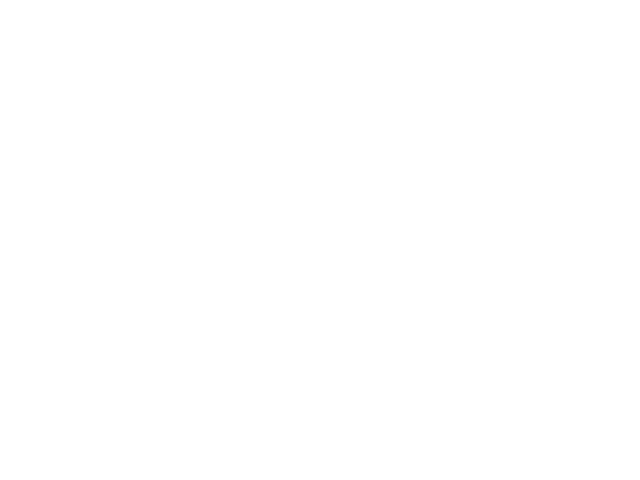

<IPython.core.display.Javascript object>


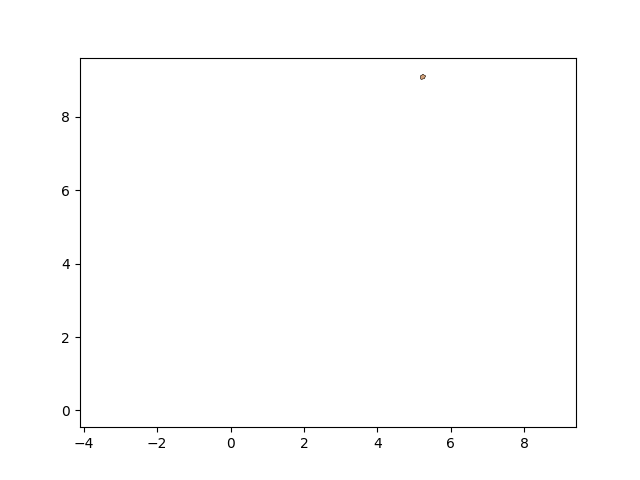

In [14]:
hole,dummy = foldable_robotics.manufacturing.calc_hole(hinges,.1)
hole = hole.to_laminate(5)
hole = foldable_robotics.manufacturing.cleanup(hole,.025,resolution = 4)
hole.plot(new=True)

<IPython.core.display.Javascript object>


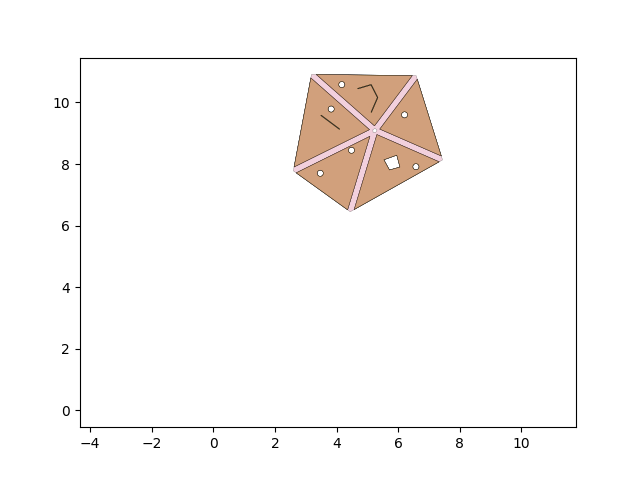

In [15]:
design1 = body- hole -simple_hinges - cuts - holes_lam
design1.plot(new=True)

<IPython.core.display.Javascript object>


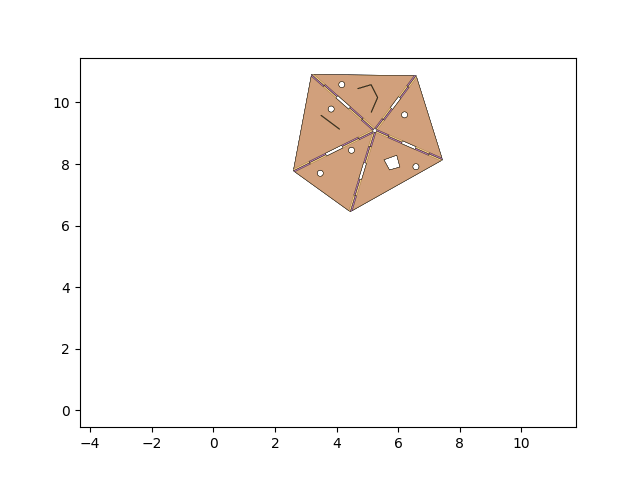

In [16]:
design2 = body- hole -castellated_hinges - cuts-holes_lam
design2.plot(new=True)

In [17]:
both = (design1 | design2.translate(10))

In [18]:
design2.export_dxf('design2.dxf')

In [19]:
design_outer = foldable_robotics.manufacturing.unary_union(design2)
sheet = (design_outer<<.5).bounding_box()
sheet=sheet.to_laminate(5)

In [20]:
support_width = .1

<IPython.core.display.Javascript object>


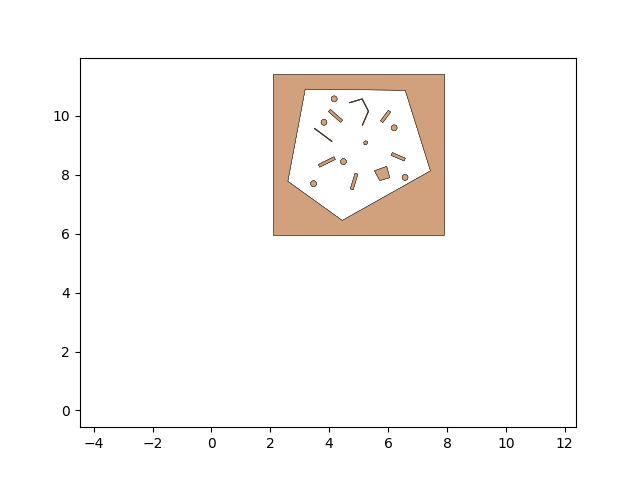

In [21]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design2)
second_pass_scrap = sheet-keepout
second_pass_scrap.plot(new=True)

Why is the center cut out of every hinge?

<IPython.core.display.Javascript object>


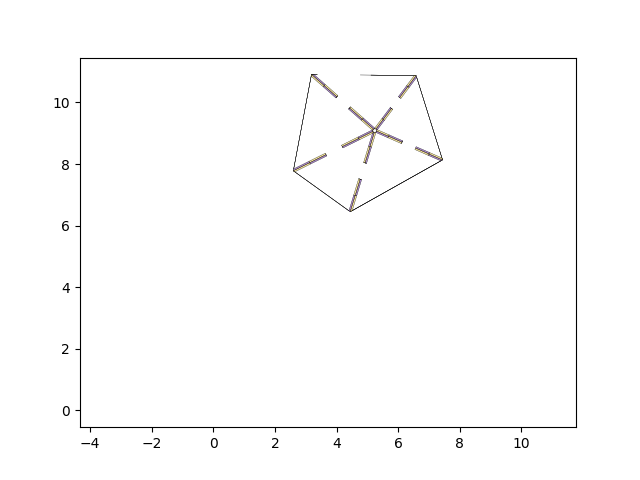

<IPython.core.display.Javascript object>


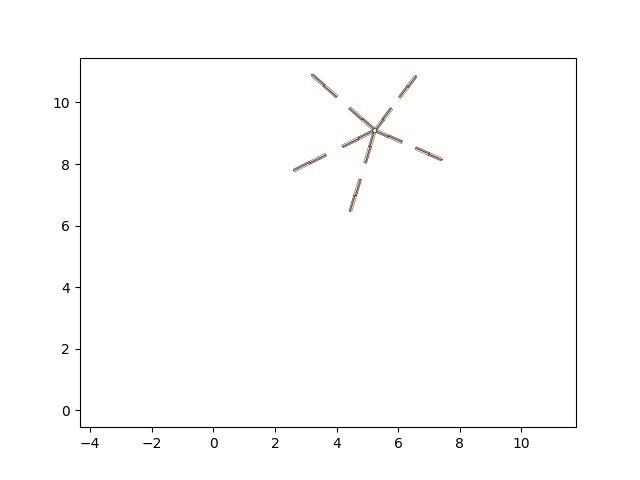

In [22]:
first_pass_scrap = sheet - design2-second_pass_scrap
first_pass_scrap.plot(new=True)
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot(new=True)

<IPython.core.display.Javascript object>


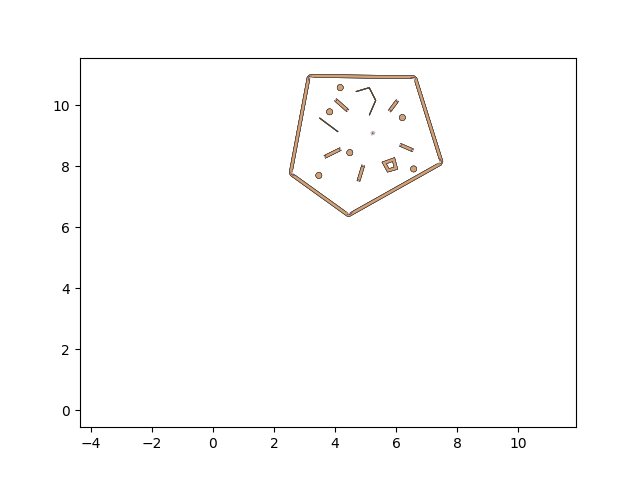

In [23]:
support = foldable_robotics.manufacturing.support(design2,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot(new=True)

Calculate the web by using only the material which can be cut, minus a gap determined by the support width.  Is that the only material you can use?

In [24]:
web = sheet-(keepout<<support_width)

<IPython.core.display.Javascript object>


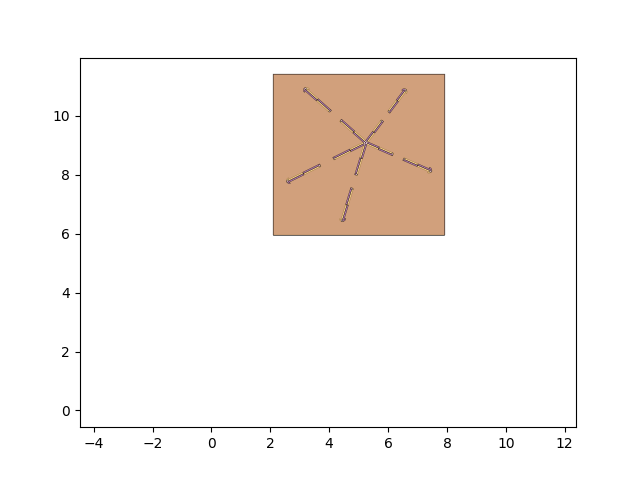

In [25]:
supported_design = web|design2|support
supported_design.plot(new=True)

<IPython.core.display.Javascript object>


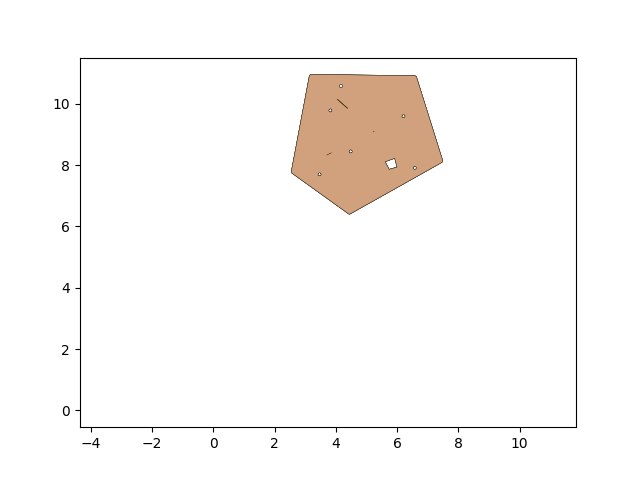

In [26]:
cut_line = keepout<<.05

cut_line.plot(new=True)

<IPython.core.display.Javascript object>


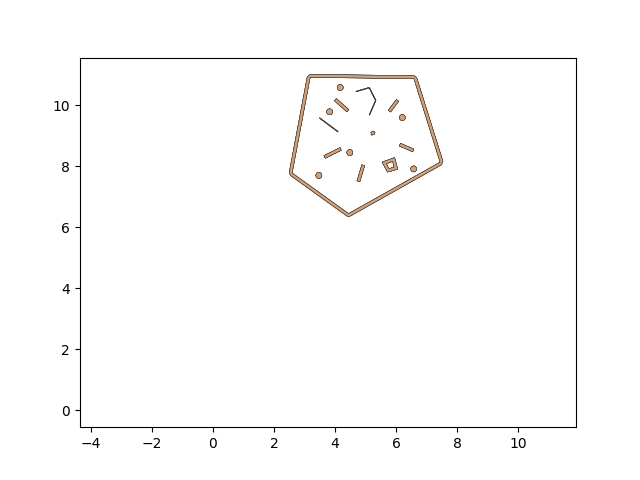

In [27]:
cut_material = (keepout<<.1)-keepout
cut_material.plot(new=True)

<IPython.core.display.Javascript object>


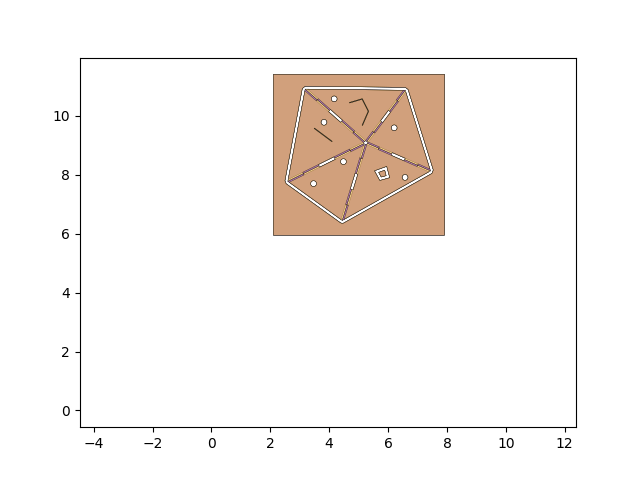

In [28]:
remaining_material = supported_design-cut_material
remaining_material.plot(new=True)

<IPython.core.display.Javascript object>


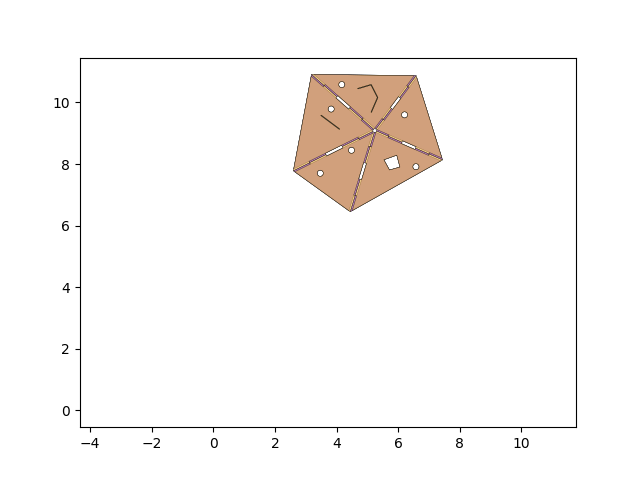

C:\Miniconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


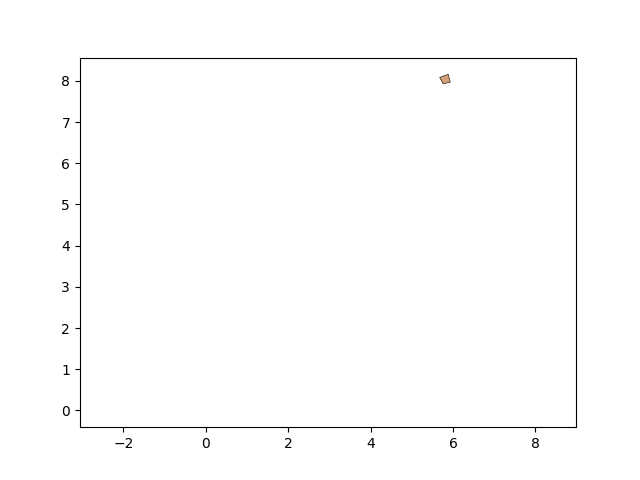

<IPython.core.display.Javascript object>


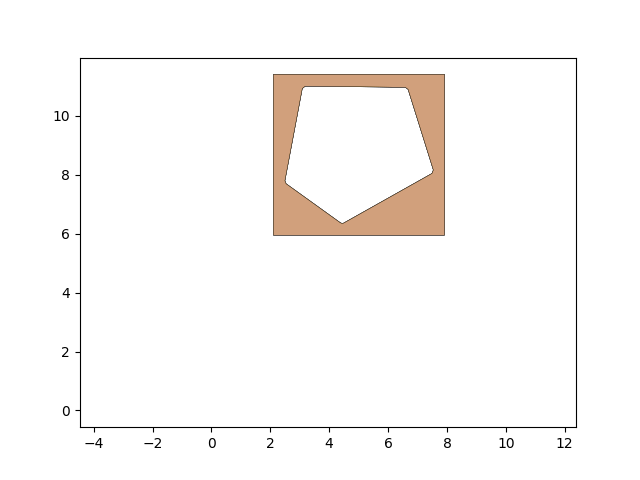

In [29]:
results = foldable_robotics.manufacturing.find_connected(remaining_material,[False,True,False,True,False])
for item in results:
    item.plot(new=True)

C:\Miniconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


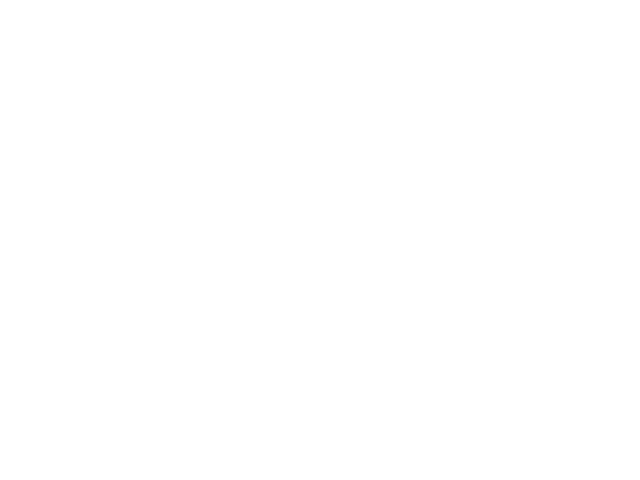

In [30]:
zero = results[0]^design2
zero = foldable_robotics.manufacturing.cleanup(zero,.00001)
zero.plot(new=True)

In [31]:
zero[0].geoms


[]

C:\Miniconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


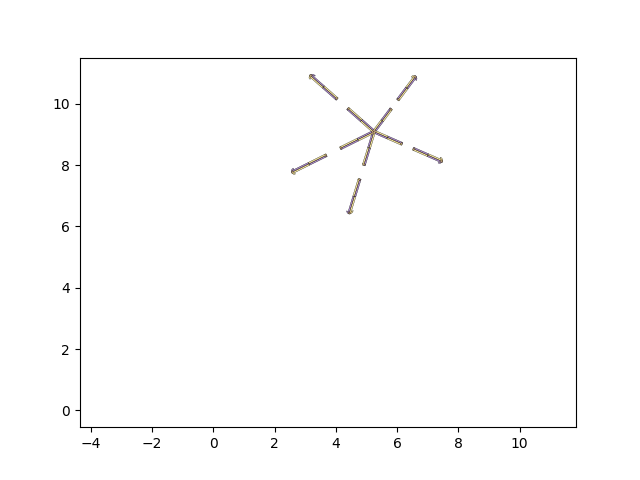

In [32]:
first_pass_cut = sheet-supported_design
first_pass_cut.plot(new=True)

C:\Miniconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


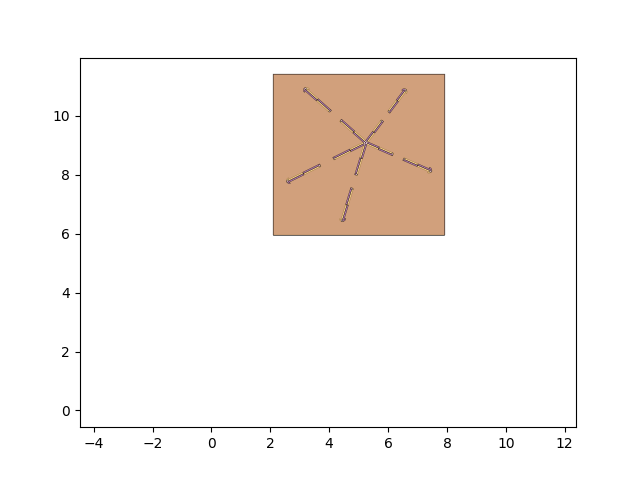

In [33]:
first_pass_scrap_new = sheet-first_pass_cut
first_pass_scrap_new.plot(new=True)